Evidence Lower Bound (ELBO)

$$\text{Eq} [log \frac{p(D, \theta}{q(\theta)}]$$
$$\text{Eq Gradient } log p (D, \theta)$$

- Use Monte Carlo 
- Mini Batches stochastic gradient descent 

In [1]:
# Modified and extended from AustinRochford, 2016 http://www.monetate.com/

from IPython.display import HTML

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import seaborn as sns
import tensorflow as tf
from theano import shared, tensor as tt

In [3]:
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

plt.rc('animation', writer='avconv')

In [4]:
SEED = 20190518 # from random.org, for reproducibility

np.random.seed(SEED)

### Beta-binomial Model Example

In [5]:
x_beta_binomial = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

with pm.Model() as beta_binomial_model:
    p_beta_binomial = pm.Uniform('p', 0., 1.)

with beta_binomial_model:
    x_obs = pm.Bernoulli('x', p_beta_binomial,
                         observed=x_beta_binomial)

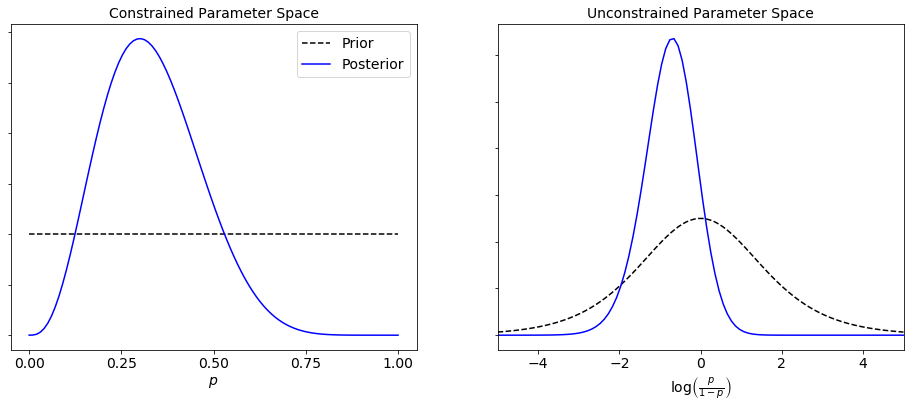

In [6]:

# plot the transformed (unconstrained) parameters
fig, (const_ax, trans_ax) = plt.subplots(ncols=2, figsize=(16, 6))

prior = sp.stats.uniform(0, 1)
posterior = sp.stats.beta(1 + x_beta_binomial.sum(),
                          1 + (1 - x_beta_binomial).sum())

# constrained distribution plots
const_x = np.linspace(0, 1, 100)
const_ax.plot(const_x, prior.pdf(const_x),
              '--', c='k', label='Prior');

def logit_trans_pdf(pdf, x):
    x_logit = sp.special.logit(x)
    return pdf(x_logit) / (x * (1 - x))

const_ax.plot(const_x, posterior.pdf(const_x),
              c='blue', label='Posterior');

const_ax.set_xticks(np.linspace(0, 1, 5));
const_ax.set_xlabel(r'$p$');
const_ax.set_yticklabels([]);
const_ax.set_title('Constrained Parameter Space');
const_ax.legend(loc=1);

# unconstrained distribution plots
def expit_trans_pdf(pdf, x):
    x_expit = sp.special.expit(x)
    return pdf(x_expit) * x_expit * (1 - x_expit)

trans_x = np.linspace(-5, 5, 100)
trans_ax.plot(trans_x, expit_trans_pdf(prior.pdf, trans_x),
              '--', c='k');
trans_ax.plot(trans_x, expit_trans_pdf(posterior.pdf, trans_x),
              c='blue');

trans_ax.set_xlim(trans_x.min(), trans_x.max());
trans_ax.set_xlabel(r'$\log\left(\frac{p}{1 - p}\right)$');
trans_ax.set_yticklabels([]);
trans_ax.set_title('Unconstrained Parameter Space');

In [34]:

with beta_binomial_model:
    approx = pm.fit(40000, method = 'advi', random_seed = SEED)

Average Loss = 7.196: 100%|██████████| 40000/40000 [00:08<00:00, 4451.18it/s] 
Finished [100%]: Average Loss = 7.1959


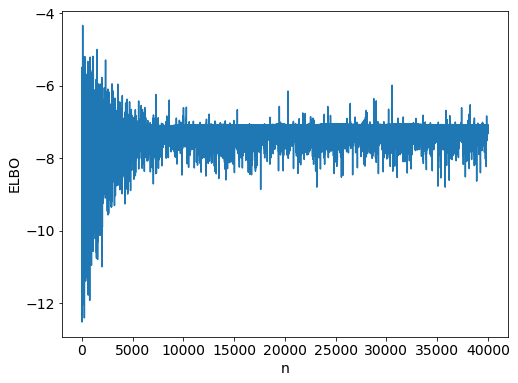

In [35]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

#plt.plot(approx.hist);

In [9]:

advi_bb_mu = approx.mean.eval()
advi_bb_std = approx.std.eval()
advi_bb_dist = sp.stats.norm(advi_bb_mu, advi_bb_std)

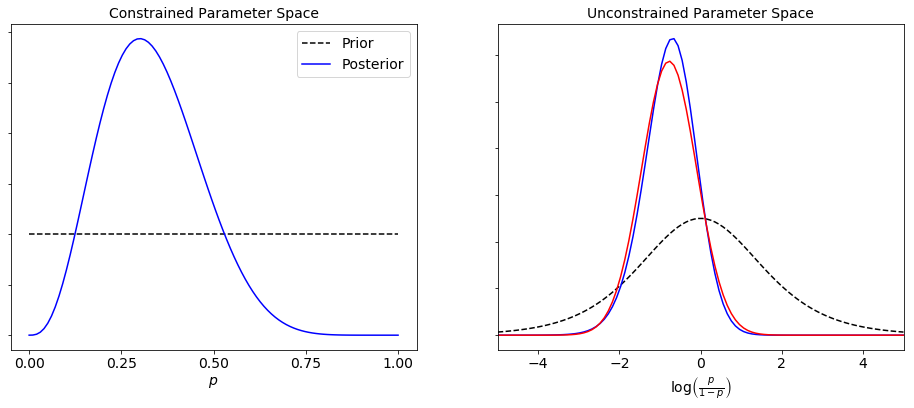

In [10]:

# plot the ADVI gaussian approximation to the unconstrained posterior
trans_ax.plot(trans_x, advi_bb_dist.pdf(trans_x),
              c='red', label='Variational approximation');
fig

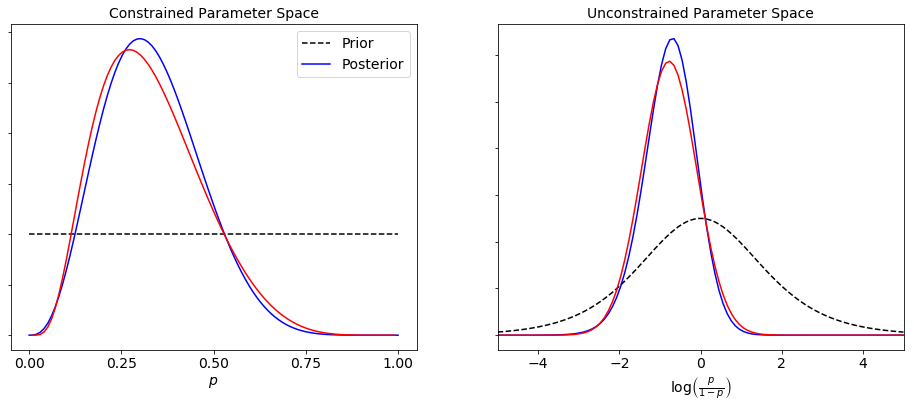

In [11]:
# plot the ADVI approximation to the true posterior
const_ax.plot(const_x, logit_trans_pdf(advi_bb_dist.pdf, const_x),
              c='red', label='Variational approximation');
fig

### Dependent Density Regression Example

Find a mixture of regression equations to fit the data where the number of mixtures is unknown

The data for his example come from the LIDAR data in Larry Wasserman's book [_All of Nonparametric Statistics_](http://www.stat.cmu.edu/~larry/all-of-nonpar/).

In [12]:
# read and standardize the LIDAR data
path = '/Users/donaldbrown/Dropbox/department/Classes/Data/'
file = 'lidar.csv'
lidar_df = pd.read_csv(path+file, sep=',')

In [13]:
lidar_df.head()

,range,logratio
0,390,-0.050356
1,391,-0.060097
2,393,-0.041901
3,394,-0.050985
4,396,-0.059913


In [14]:
# Standardize the variables
from sklearn.preprocessing import StandardScaler 

lidar_df[['range', 'logratio']] = StandardScaler().fit_transform(lidar_df[['range','logratio']])

/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


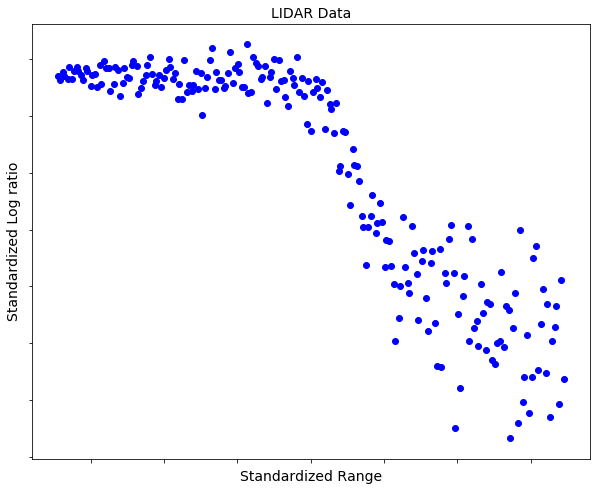

In [15]:
# plot the LIDAR dataset
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(lidar_df.range, lidar_df.logratio,
           c="blue", zorder=10);

ax.set_xticklabels([]);
ax.set_xlabel('Standardized Range');

ax.set_yticklabels([]);
ax.set_ylabel('Standardized Log ratio');

ax.set_title('LIDAR Data');

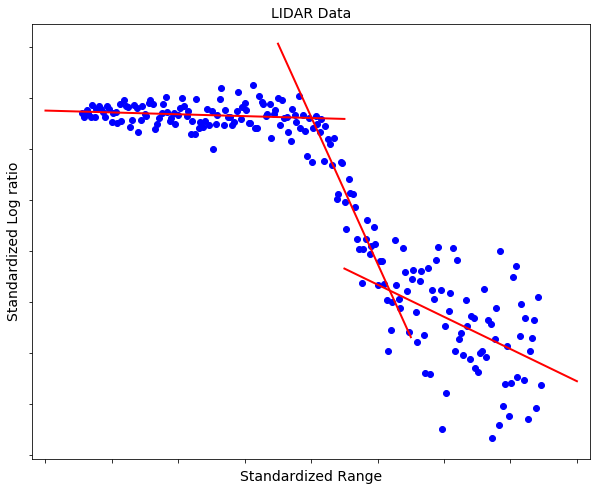

In [16]:
# fit and plot a few linear models on different intervals
# of the LIDAR data
LIDAR_KNOTS = np.array([-1.75, 0., 0.5, 1.75])

for left_knot, right_knot in zip(LIDAR_KNOTS[:-1], LIDAR_KNOTS[1:]):
    between_knots = lidar_df.range.between(left_knot, right_knot)
    slope, intercept, *_ = sp.stats.linregress(lidar_df.range[between_knots].values,
                                               lidar_df.logratio[between_knots].values)

    knot_plot_x = np.linspace(left_knot - 0.25, right_knot + 0.25, 100)
    ax.plot(knot_plot_x, intercept + slope * knot_plot_x, 
            c='red', lw=2, zorder=100);
    
ax.set_xlim(-2.1, 2.1);
fig

#### Mixture weights

The model has infinitely many mixture components, but set an upper bound of $K$

$$
\begin{align*}
\alpha_1, \ldots, \alpha_K
    & \sim N(0, 1) \\
\beta_1, \ldots, \beta_K
    & \sim N(0, 1) \\
\boldsymbol{\pi} \ |\ \boldsymbol{\alpha}, \boldsymbol{\beta}, x
    & \sim \textrm{Logit-Stick-Breaking}(\boldsymbol{\alpha} + \boldsymbol{\beta} x) \\
\end{align*}
$$


In [17]:
# turn the LIDAR observations into column vectors
# this is important for broadcasting in following
# calculations
std_range = lidar_df.range.values[:, np.newaxis]
std_logratio = lidar_df.logratio.values[:, np.newaxis]

The [stick-breaking process](https://en.wikipedia.org/wiki/Dirichlet_process#The_stick-breaking_process) transforms an arbitrary set of values in the interval $[0, 1]$ to a set of weights in $[0, 1]$ that sum to one.

In [18]:
def stick_breaking(v):
    """
    Perform a stick breaking transformation along
    the second axis of v
    """
    return v * tt.concatenate([tt.ones_like(v[:, :1]),
                               tt.extra_ops.cumprod(1 - v, axis=1)[:, :-1]],
                              axis=1)

In [19]:
K = 20

x_lidar = shared(std_range, broadcastable=(False, True))

with pm.Model() as lidar_model:
    alpha = pm.Normal('alpha', 0., 1., shape=K)
    beta = pm.Normal('beta', 0., 1., shape=K)
    
    v = tt.nnet.sigmoid(alpha + beta * x_lidar)
    pi = pm.Deterministic('pi', stick_breaking(v))

#### Component linear models

$$
\begin{align*}
\gamma_1, \ldots, \gamma_K
    & \sim N(0, 100) \\
\delta_1, \ldots, \delta_K
    & \sim N(0, 100) \\
\tau_1, \ldots, \tau_K
    & \sim \textrm{Gamma}(1, 1) \\
Y_i\ |\ \gamma_i, \delta_i, \tau_i, x
    & \sim N(\gamma_i + \delta_i x, \tau_i^{-1})
\end{align*}
$$

In [20]:
with lidar_model:
    gamma = pm.Normal('gamma', 0., 100., shape=K)
    delta = pm.Normal('delta', 0., 100., shape=K)
    tau = pm.Gamma('tau', 1., 1., shape=K)

    ys = pm.Deterministic('ys', gamma + delta * x_lidar)

#### Observation model

$$
\begin{align*}
Y\ |\ \boldsymbol{\alpha}, \boldsymbol{\beta}, \boldsymbol{\gamma}, \boldsymbol{\delta}, \boldsymbol{\tau}, x
    & = \sum_{i = 1}^K \pi_i Y_i \\
\end{align*}
$$

In [21]:
# Using a normal mixture class as a way to marginalize over the categorical indicators

def normal_mixture_rvs(*args, **kwargs):
    w = kwargs['w']
    mu = kwargs['mu']
    tau = kwargs['tau']
    
    size = kwargs['size']
    
    component = np.array([np.random.choice(w.shape[1], size=size, p=w_ / w_.sum())
                          for w_ in w])
    
    return sp.stats.norm.rvs(mu[np.arange(w.shape[0]), component], tau[component]**-0.5)

class NormalMixture(pm.distributions.Continuous):
    def __init__(self, w, mu, tau, *args, **kwargs):
        """
        w is a tensor of mixture weights
        mu is a tensor of the means of the component normal distributions
        tau is a tensor of the precisions of the component normal distributions
        """
        super(NormalMixture, self).__init__(*args, **kwargs)
        
        self.w = w
        self.mu = mu
        self.tau = tau
        
        self.mean = (w * mu).sum()
    
    def random(self, point=None, size=None, repeat=None):
        """
        Draw a random sample from a normal mixture model
        """
        w, mu, tau = draw_values([self.w, self.mu, self.tau], point=point)
        
        return normal_mixture_rvs(w=w, mu=mu, tau=tau, size=size)
    
    def logp(self, value):
        """
        The log density of then normal mixture model
        """
        w = self.w
        mu = self.mu
        tau = self.tau
        
        return bound(logsumexp(tt.log(w) + (-tau * (value - mu)**2 + tt.log(tau / np.pi / 2.)) / 2.,
                               axis=1).sum(),
                     tau >=0, w >= 0, w <= 1)

In [22]:
with lidar_model:
    lidar_obs = NormalMixture('lidar_obs', pi, ys, tau,
                              observed=std_logratio)

In [27]:
# The ADVI optimization 

N_ADVI_ITER = 40000

with lidar_model:
    advi_fit = pm.fit(n=N_ADVI_ITER,method='advi', random_seed = SEED)

Average Loss = -2.424e+05: 100%|██████████| 40000/40000 [00:27<00:00, 1470.59it/s] 
Finished [100%]: Average Loss = -2.4245e+05


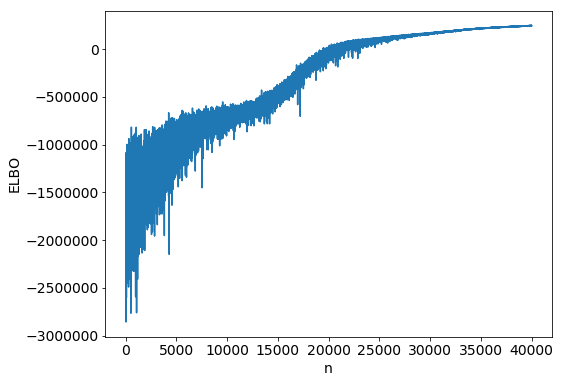

In [28]:
# plot the ELBO over time

advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)


#### Posterior predictions

In [29]:
# Posterior Predictions

PPC_SAMPLES = 5000

lidar_ppc_x = np.linspace(std_range.min() - 0.05,
                          std_range.max() + 0.05,
                          100)

# # sample from the variational posterior distribution

advi_trace = advi_fit.sample(PPC_SAMPLES)

# sample from the posterior predictive distribution
x_lidar.set_value(lidar_ppc_x[:, np.newaxis])
    #std_range.set_value(lidar_ppc_x[:, np.newaxis])
with lidar_model:
    advi_ppc_trace = pm.sample_posterior_predictive(advi_trace, samples=PPC_SAMPLES)

#with lidar_model:
    # sample from the variational posterior distribution
#    advi_trace = advi_fit.sample(PPC_SAMPLES)

    # sample from the posterior predictive distribution
#    x_lidar.set_value(lidar_ppc_x[:, np.newaxis])
#    advi_ppc_trace = pm.sample_posterior_predictive(advi_trace, samples=PPC_SAMPLES)

100%|██████████| 5000/5000 [00:58<00:00, 85.29it/s]


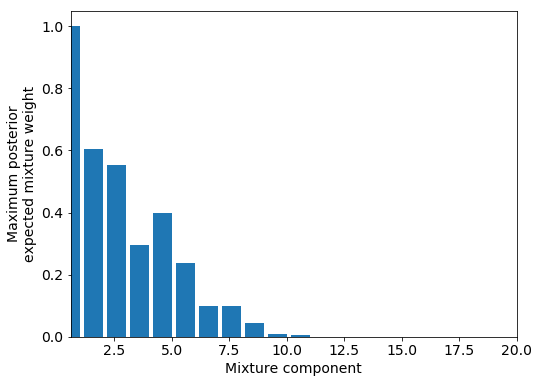

In [30]:
# plot the component mixture weights to assess the impact of truncation
fig, ax = plt.subplots()

ax.bar(np.arange(K) + 1 - 0.4, advi_trace['pi'].mean(axis=0).max(axis=0),
       lw=0);

ax.set_xlim(1 - 0.4, K);
ax.set_xlabel('Mixture component');

ax.set_ylabel('Maximum posterior\nexpected mixture weight');

In [32]:
# # sample from the variational posterior distribution

advi_trace = advi_fit.sample(PPC_SAMPLES)

# sample from the posterior predictive distribution
x_lidar.set_value(lidar_ppc_x[:, np.newaxis])
    #std_range.set_value(lidar_ppc_x[:, np.newaxis])
with lidar_model:
    advi_ppc_trace = pm.sample_posterior_predictive(advi_trace, samples=PPC_SAMPLES)

100%|██████████| 5000/5000 [00:27<00:00, 184.79it/s]


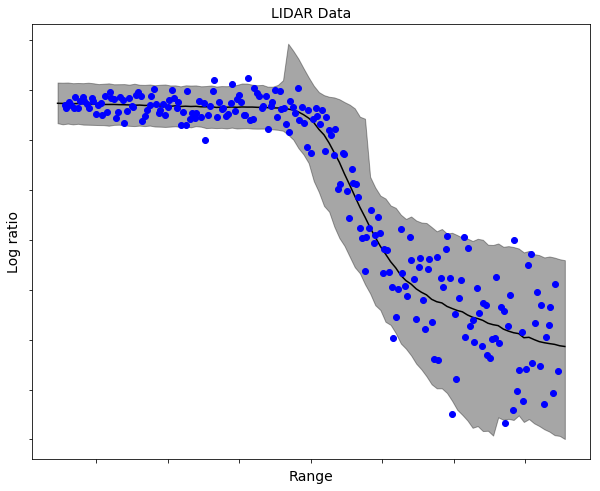

In [33]:
# # plot the posterior predictions for the LIDAR data
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(lidar_df.range, lidar_df.logratio,
            c='blue', zorder=10);

low, high = np.percentile(advi_ppc_trace['lidar_obs'], [2.5, 97.5], axis=0)
ax.fill_between(lidar_ppc_x, low, high, color='k', alpha=0.35, zorder=5);

ax.plot(lidar_ppc_x, advi_ppc_trace['lidar_obs'].mean(axis=0), c='k', zorder=6);

ax.set_xticklabels([]);
ax.set_xlabel('Range');

ax.set_yticklabels([]);
ax.set_ylabel('Log ratio');

ax.set_title('LIDAR Data');